In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 임포트
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from google.colab import files
%matplotlib inline

In [3]:
# 디렉터리 재설정
os.chdir('/content/drive/MyDrive/DL/projoect')
os.getcwd()

'/content/drive/MyDrive/DL/projoect'

In [4]:
# 데이터 크기 재설정
def resize_data(train_data, size):
    resize_data = []
    for img in train_data:
        resize_img = cv2.resize(img, size)
        resize_data.append(resize_img)
    return np.array(resize_data)    

In [5]:
# plot graph & matrix
def plot_result(hist, cf_mat, test_res):
  hist_dict = hist.history
  acc = hist_dict['acc']
  val_acc = hist_dict['val_acc']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs = range(1, len(acc) + 1)
  epochs_num = epochs[-1]

  total_acc = test_res[1]
  recall_nor_vs = (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2]) / (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2] + cf_mat[1][0] + cf_mat[2][0])
  precision_nor_vs = (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2]) / (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2] + cf_mat[0][1] + cf_mat[0][2])
  f1_score_nor_vs = 2*recall_nor_vs*precision_nor_vs / (recall_nor_vs + precision_nor_vs)

  acc_cov_pne = (cf_mat[1][1] + cf_mat[2][2]) / (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2])
  recall_cov_pne = cf_mat[2][2] / (cf_mat[2][1] + cf_mat[2][2])
  perf_y = [total_acc, recall_nor_vs, precision_nor_vs, f1_score_nor_vs, acc_cov_pne, recall_cov_pne]
  perf_x = ['acc(total)', 'recall(nor vs)', 'precision(nor vs)', 'f1(nor vs)', 'acc(cov&pne)', 'recall(cov&pne)']

  plt.style.use(['seaborn'])
  fig = plt.figure(figsize=(18, 5))

  if epochs_num//5 < 1:
    x_interval = 1
  else:
    x_interval = epochs_num//5

  fig.add_subplot(1, 3, 1)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy', size=18)
  plt.xlabel('Epochs', size=14)
  plt.xticks(list(range(1, epochs_num+1, x_interval)))
  plt.ylabel('Accuracy', size=14)
  plt.legend()

  ax2 = fig.add_subplot(1, 3, 2)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss', size=18)
  plt.xlabel('Epochs', size=14)
  plt.xticks(list(range(1, epochs_num+1, x_interval)))
  plt.ylabel('Accuracy', size=14)
  plt.legend()

  ax3 = fig.add_subplot(1, 3, 3)
  plt.plot(perf_x, perf_y)
  plt.title('Model performance evaluation', size=18)
  plt.xticks(size=12, rotation=45)
  plt.show()


def true_label_ftn(label_):
  tr_label = []
  for i in label_:
    for th, j in enumerate(i):
      if j == 1:
        tr_label.append(th)

  return np.array(tr_label)

def print_result(res_name, res, per=0):
  if per:
    print('{0:^35} |  {1:0.4f}'.format(res_name, res))
  else:
    print('{0:^35} |  {1:0.2f}%'.format(res_name, res*100))
  

def model_performance(mod, hist, data_, label_, save_name = ''):

  test_results = mod.evaluate(data_, label_, verbose=0)
  tr_label = true_label_ftn(label_)
  pred_c = mod.predict(data_)
  pred_c = np.argmax(pred_c, axis=1)

  index_list = ['NORMAL', 'PNEUMONIA', 'COVID19']
  cf_mat = confusion_matrix(tr_label, pred_c)
  cf_df = pd.DataFrame(cf_mat, index=index_list, columns=index_list)

  print('\n')
  plot_result(hist, cf_mat, test_results)
  print('\n')

  fig = plt.figure(figsize=(8, 7))
  sns.heatmap(cf_df, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 14})
  plt.title('Confusion Matrix', fontsize = 18)
  plt.xlabel('Predicted label', fontsize = 16)
  plt.ylabel('True label', fontsize = 16)

  plt.show()

  save_perform = hist.history
  save_perform['cf_mat'] = cf_mat
  save_perform['mod_eval'] = test_results
  if save_name == '':
    np.save('model_performance_save', np.array(save_perform))
    files.download('model_performance_save.npy')
  else:
    np.save('{0}_performance_savefile'.format(save_name), np.array(save_perform))
    files.download('{0}_performance_savefile'.format(save_name)+'.npy')  

In [6]:
# pre-trained model
def pre_trained_model(model_name, batch_size=32, epochs=5, opt_option='all', layer_trainable=True, dense_layer=False, regularizer=None):
    
    # optimizer   
    if opt_option == 'all':
      sgd = keras.optimizers.SGD(lr=0.001)
      sgd_momentum = keras.optimizers.SGD(lr=0.001, momentum=0.9)
      sgd_nesterov = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
      rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
      adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      nadam= keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      adamax = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      optimizers = [sgd, sgd_momentum, sgd_nesterov, rmsprop, adam, nadam, adamax]
      optimizers_name = ['sgd', 'sgd_momentum', 'sgd_nesterov', 'rmsprop', 'adam', 'nadam', 'adamax']
    
    elif opt_option == 'accel':
      sgd_momentum = keras.optimizers.SGD(lr=0.001, momentum=0.9)
      sgd_nesterov = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
      rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
      adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      nadam= keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      adamax = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      optimizers = [sgd_momentum, sgd_nesterov, rmsprop, adam, nadam, adamax]
      optimizers_name = ['sgd_momentum', 'sgd_nesterov', 'rmsprop', 'adam', 'nadam', 'adamax']
    
    elif opt_option == 'sgd':
      sgd = keras.optimizers.SGD(lr=0.001)
      sgd_momentum = keras.optimizers.SGD(lr=0.001, momentum=0.9)
      sgd_nesterov = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
      optimizers = [sgd, sgd_momentum, sgd_nesterov]
      optimizers_name = ['sgd', 'sgd_momentum', 'sgd_nesterov']
    
    elif opt_option == 'adaptive':
      rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
      adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      nadam= keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      adamax = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)
      optimizers = [rmsprop, adam, nadam, adamax]
      optimizers_name = ['rmsprop', 'adam', 'nadam', 'adamax']
    
    else: ## opt_option == 'rmsprop'
      rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
      optimizers = [rmsprop]
      optimizers_name = ['rmsprop']

    # regularizer
    if regularizer == None:
      kernel_regularizer = None
    
    elif regularizer == 'l1':
      kernel_regularizer = keras.regularizers.l1_l2(l1=0.1, l2=0)

    elif regularizer == 'l2':
      kernel_regularizer = keras.regularizers.l1_l2(l1=0, l2=0.1)

    else: ## regularizer == True
      kernel_regularizer = keras.regularizers.l1_l2(l1=0.1, l2=0.1)

    
    # modeling
    if model_name == 'VGG19':
        base_model = keras.applications.vgg19.VGG19(input_shape=[128,128,3], weights='imagenet', include_top=False)
    
    elif model_name == 'Xception':
        base_model = keras.applications.resnext.ResNeXt101(input_shape=[128,128,3], weights='imagenet', include_top=False)
    
    elif model_name == 'ResNeXt101':
        base_model = keras.applications.xception.Xception(input_shape=[128,128,3], weights='imagenet', include_top=False)
    
    elif model_name == 'InceptionV3':
        base_model = keras.applications.inception_v3.InceptionV3(input_shape=[128,128,3], weights='imagenet', include_top=False)
    
    elif model_name == 'InceptionResNetV2':
        base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=[128,128,3], weights='imagenet', include_top=False)

    elif model_name == 'DenseNet201':
        base_model = keras.applications.densenet.DenseNet201(input_shape=[128,128,3], weights='imagenet', include_top=False)
    
    else: ## model_name == 'NASNetMobile'
        base_model = keras.applications.nasnet.NASNetMobile(input_shape=[128,128,3], weights=None, include_top=False)

    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)

    # dense layer
    if dense_layer == False:
      pass
    
    elif dense_layer == True:
      x = keras.layers.Dense(1000,activation='relu', kernel_initializer='he_normal',kernel_regularizer=kernel_regularizer)(x)
      x = keras.layers.Dropout(0.5)(x)
      x = keras.layers.Dense(500,activation='relu', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
      x = keras.layers.Dropout(0.5)(x)
      x = keras.layers.Dense(100,activation='relu', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
      x = keras.layers.Dropout(0.5)(x)
    
    else: ## dense_layer == 'drop_out'
      x = keras.layers.Dense(1000,activation='relu', kernel_initializer='he_normal',kernel_regularizer=kernel_regularizer)(x)
      x = keras.layers.Dense(500,activation='relu', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
      x = keras.layers.Dense(100,activation='relu', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)

    x = keras.layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=x)
    
    model_list = []
    val_loss_list = []
    val_acc_list = []
    test_loss_list =[]
    test_acc_list = []
    
    for opt, opt_name in zip(optimizers, optimizers_name):
        
        start_time = time.time()

        # layer의 trainable 여부
        if layer_trainable == False:
          for layer in base_model.layers:
              layer.trainable = False
        
        elif layer_trainable == 'half':
          for layer in base_model.layers[:152]:
              layer.trainable = False

        # compiling
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc']) 
  
        # 디렉터리 재설정
        ##os.chdir('/content/drive/MyDrive/DL/project')
        ##path = os.path.join(model_name, opt_name) 
        ##os.makedirs(path, exist_ok=True)
        ##os.chdir(path)

        # callback
        callbacks = [
                      # keras.callbacks.ModelCheckpoint(filepath='{epoch:02d}-{val_loss:.4f}.h5',monitor='val_loss', save_best_only=True, verbose=1),
                      keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
                      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001) 
        ]
               
        print('*'*40 + model_name + '_' + opt_name + '*'*40)

        # fitting
        history = model.fit(train_data, train_label,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.2,
                            callbacks=callbacks)
        
        print('-'*35 + model_name + '_' + opt_name + '_evaluation'+ '-'*35)

        # evaluation
        score = model.evaluate(test_data ,test_label)
        end_time = time.time()
        print('-'*50 + 'result' + '-'*50)
        print("test loss: {0:0.4f}".format(score[0]))
        print("test acc: {0:0.4f}".format(score[1]))
        print('WorkingTime: {0:0.2f}sec'.format(end_time-start_time))

        # 데이터프레임
        model_name_opt = model_name + '_' + opt_name

        model_list.append(model_name_opt)
        val_loss_list.append(history.history['val_loss'][-1])
        val_acc_list.append(history.history['val_acc'][-1])
        test_loss_list.append(score[0])
        test_acc_list.append(score[1])

        # graph & matrix
        model_performance(model, history, test_data, test_label, save_name=model_name+'_'+opt_name+'_'+str(dense_layer)+'_'+str(regularizer))
    
    df = pd.DataFrame({'model' : model_list, 'val_loss' : val_loss_list, 'val_acc' : val_acc_list, 'test_loss': test_loss_list, 'test_acc' : test_acc_list})
    return df

In [7]:
# 데이터 적재
train_data = np.load('train_data128_pre.npy')
train_label = np.load('train_label128_pre.npy')
test_data = np.load('test_data128_pre.npy')
test_label = np.load('test_label128_pre.npy')

In [8]:
# 데이터 크기 확인
print('train set size:', train_data.shape, ',', train_label.shape)
print('test set size: ', test_data.shape, ',', test_label.shape)

train set size: (10500, 128, 128, 3) , (10500, 3)
test set size:  (1288, 128, 128, 3) , (1288, 3)


# 1. Freezing pre-trained model layer: 0% (True)

****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 41s 116ms/step - loss: 0.4687 - acc: 0.8534 - val_loss: 135.4770 - val_acc: 0.3824
Epoch 2/100
263/263 [==============================] - 29s 110ms/step - loss: 0.1511 - acc: 0.9478 - val_loss: 0.4190 - val_acc: 0.9595
Epoch 3/100
263/263 [==============================] - 29s 112ms/step - loss: 0.0995 - acc: 0.9642 - val_loss: 1.2904 - val_acc: 0.9014
Epoch 4/100
263/263 [==============================] - 30s 112ms/step - loss: 0.0773 - acc: 0.9728 - val_loss: 0.7491 - val_acc: 0.7967
Epoch 5/100
263/263 [==============================] - 30s 113ms/step - loss: 0.0546 - acc: 0.9800 - val_loss: 0.1533 - val_acc: 0.9519
Epoch 6/100
263/263 [==============================] - 30s 113ms/step - loss: 0.0443 - acc: 0.9868 - val_loss: 1.5875 - val_acc: 0.8476
Epoch 7/100
263/263 [==============================] - 30s 113ms/step - loss: 0.03

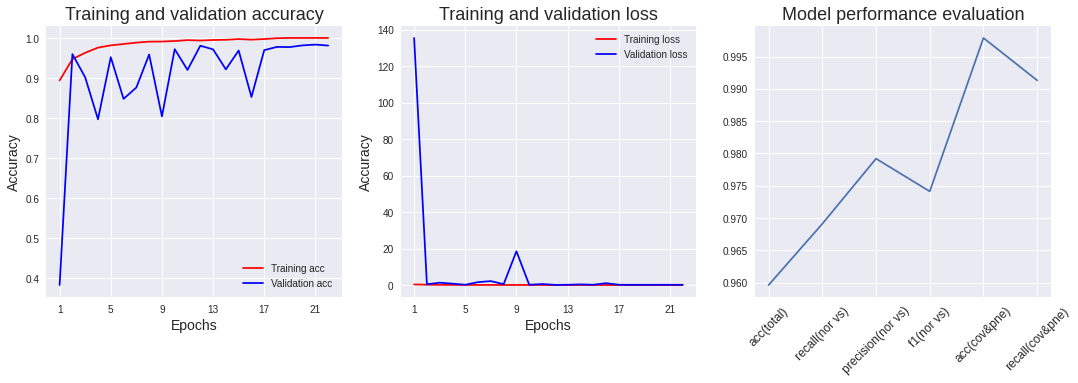

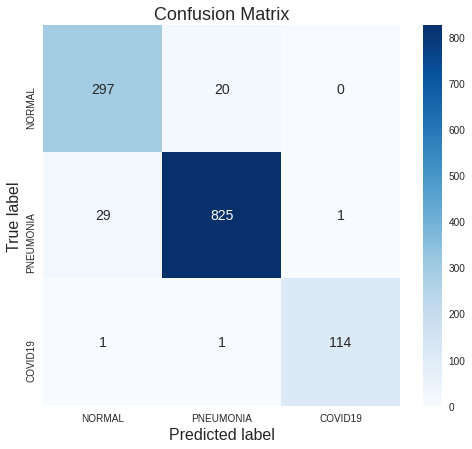

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rms_prop', layer_trainable=True, dense_layer=False, regularizer=None)

# 2. Freezing pre-trained model layer: 50%



87916544/87910968 [==============================] - 1s 0us/step
****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 62s 81ms/step - loss: 0.5070 - acc: 0.8485 - val_loss: 69.4939 - val_acc: 0.4543
Epoch 2/100
263/263 [==============================] - 18s 68ms/step - loss: 0.1194 - acc: 0.9583 - val_loss: 4.2577 - val_acc: 0.8476
Epoch 3/100
263/263 [==============================] - 18s 69ms/step - loss: 0.0787 - acc: 0.9726 - val_loss: 0.2111 - val_acc: 0.9619
Epoch 4/100
263/263 [==============================] - 18s 69ms/step - loss: 0.0519 - acc: 0.9835 - val_loss: 0.1793 - val_acc: 0.9671
Epoch 5/100
263/263 [==============================] - 18s 70ms/step - loss: 0.0455 - acc: 0.9848 - val_loss: 0.1633 - val_acc: 0.9500
Epoch 6/100
263/263 [==============================] - 19s 71ms/step - loss: 0.0235 - acc: 0.9921 - val_loss: 0.1276 - val_acc: 0.9633
Epoch 7/100
263/263 [===

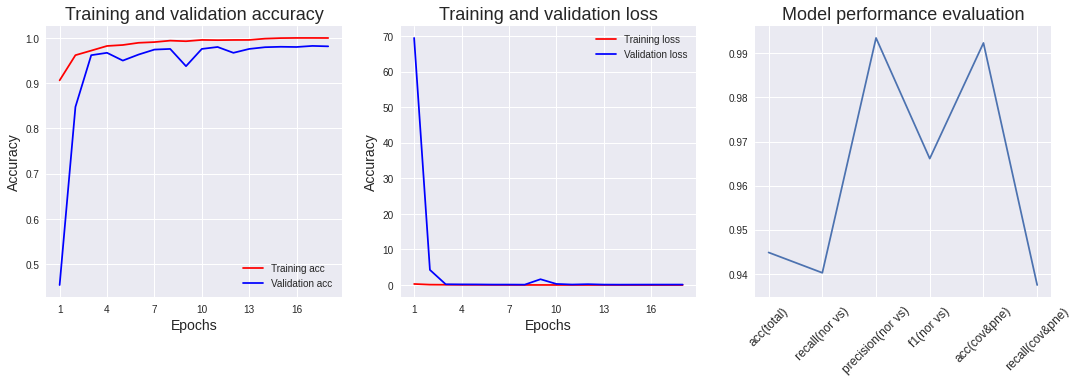

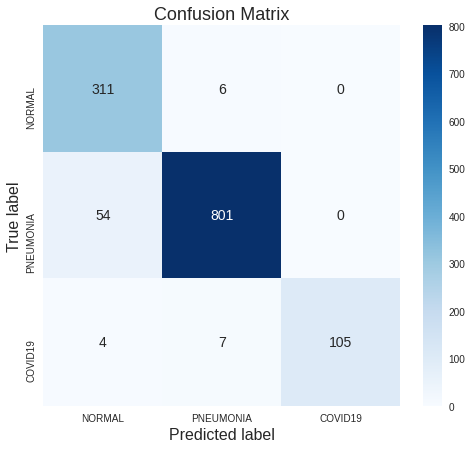

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rms_prop', layer_trainable='half', dense_layer=False, regularizer=None)

# 3. Freezing pre-trained model layer: 100%(False)

****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 15s 42ms/step - loss: 0.9092 - acc: 0.7419 - val_loss: 0.3841 - val_acc: 0.8719
Epoch 2/100
263/263 [==============================] - 10s 37ms/step - loss: 0.4394 - acc: 0.8661 - val_loss: 0.3203 - val_acc: 0.8914
Epoch 3/100
263/263 [==============================] - 10s 37ms/step - loss: 0.3349 - acc: 0.8894 - val_loss: 0.4276 - val_acc: 0.8700
Epoch 4/100
263/263 [==============================] - 10s 37ms/step - loss: 0.3107 - acc: 0.9024 - val_loss: 0.3565 - val_acc: 0.8900
Epoch 5/100
263/263 [==============================] - 10s 37ms/step - loss: 0.2723 - acc: 0.9037 - val_loss: 0.4913 - val_acc: 0.8605
Epoch 6/100
263/263 [==============================] - 10s 37ms/step - loss: 0.2946 - acc: 0.9034 - val_loss: 0.5692 - val_acc: 0.8443
Epoch 7/100
263/263 [==============================] - 10s 37ms/step - loss: 0.2683 - acc:

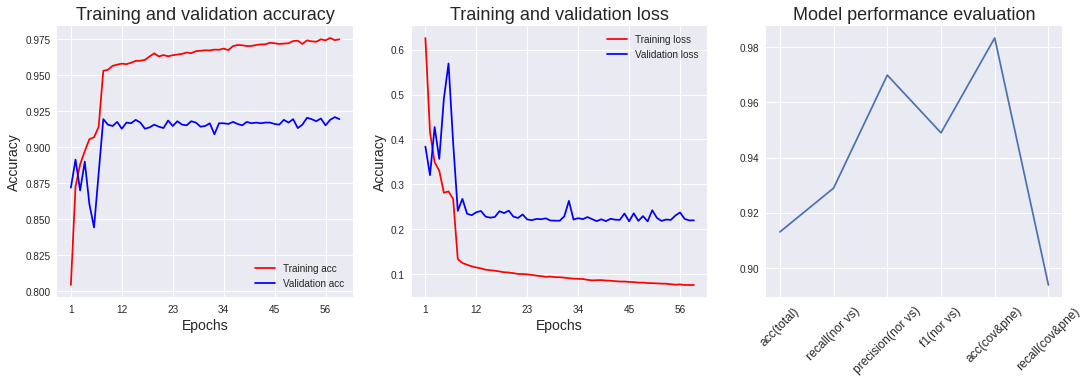

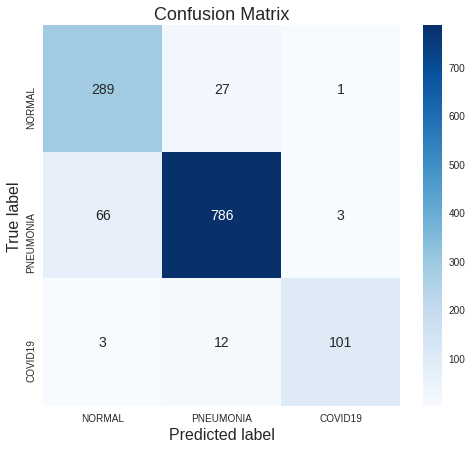

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rms_prop', layer_trainable=False, dense_layer=False, regularizer=None)

# 4. Dense layer: O

****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 42s 119ms/step - loss: 0.9869 - acc: 0.6983 - val_loss: 756.0930 - val_acc: 0.7338
Epoch 2/100
263/263 [==============================] - 30s 114ms/step - loss: 0.4175 - acc: 0.9010 - val_loss: 582.1122 - val_acc: 0.8276
Epoch 3/100
263/263 [==============================] - 30s 113ms/step - loss: 0.2788 - acc: 0.9285 - val_loss: 2.0304 - val_acc: 0.8924
Epoch 4/100
263/263 [==============================] - 30s 114ms/step - loss: 0.3015 - acc: 0.9480 - val_loss: 0.6217 - val_acc: 0.9357
Epoch 5/100
263/263 [==============================] - 30s 115ms/step - loss: 0.2113 - acc: 0.9471 - val_loss: 203.6176 - val_acc: 0.7810
Epoch 6/100
263/263 [==============================] - 30s 114ms/step - loss: 0.3207 - acc: 0.9345 - val_loss: 0.6030 - val_acc: 0.9310
Epoch 7/100
263/263 [==============================] - 30s 113ms/step - loss: 

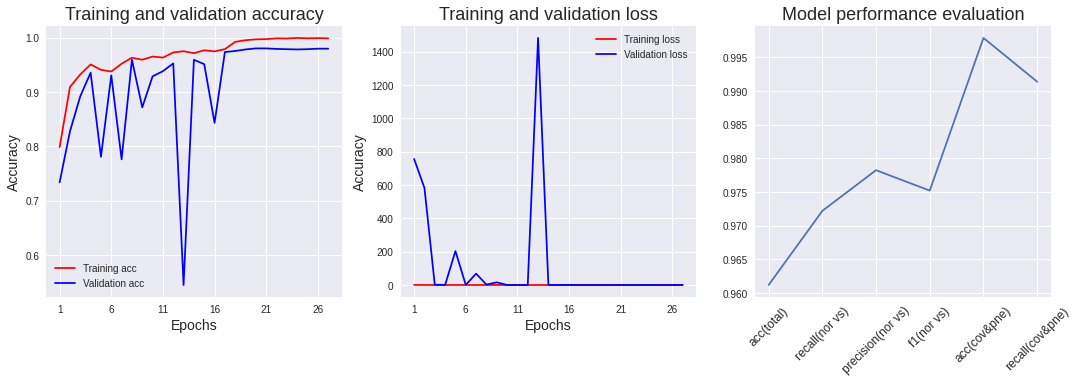

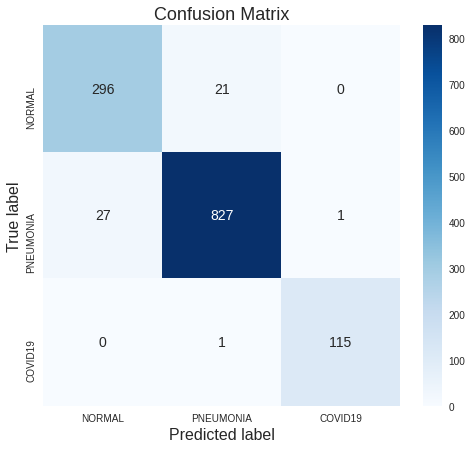

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rmsprop', layer_trainable=True, dense_layer=True, regularizer=None)

# 5. Dense layer: O + Dropout(0.5)

****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 42s 118ms/step - loss: 0.9727 - acc: 0.7976 - val_loss: 278.3600 - val_acc: 0.4429
Epoch 2/100
263/263 [==============================] - 30s 115ms/step - loss: 0.2374 - acc: 0.9261 - val_loss: 0.4606 - val_acc: 0.9081
Epoch 3/100
263/263 [==============================] - 30s 113ms/step - loss: 0.1377 - acc: 0.9596 - val_loss: 0.1632 - val_acc: 0.9662
Epoch 4/100
263/263 [==============================] - 30s 114ms/step - loss: 0.1153 - acc: 0.9683 - val_loss: 0.1958 - val_acc: 0.9371
Epoch 5/100
263/263 [==============================] - 30s 113ms/step - loss: 0.1302 - acc: 0.9721 - val_loss: 0.1686 - val_acc: 0.9686
Epoch 6/100
263/263 [==============================] - 30s 113ms/step - loss: 0.0736 - acc: 0.9820 - val_loss: 5.6982 - val_acc: 0.6343
Epoch 7/100
263/263 [==============================] - 30s 113ms/step - loss: 0.06

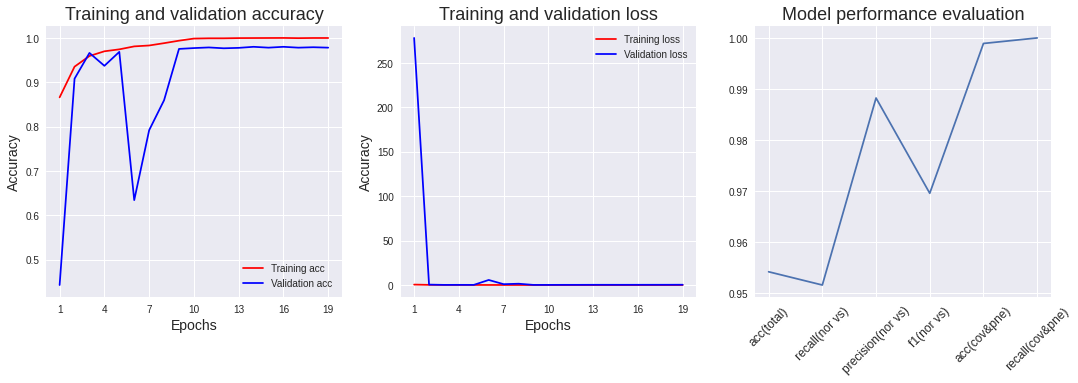

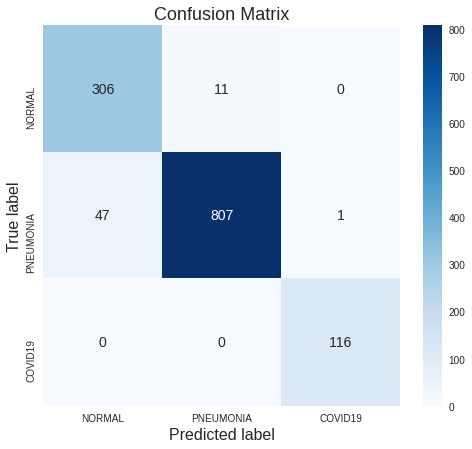

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rmsprop', layer_trainable=True, dense_layer='drop_out', regularizer=None)

# 6. Regularizer: L1 (0.1)

****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 41s 117ms/step - loss: 0.5752 - acc: 0.8217 - val_loss: 0.2461 - val_acc: 0.9276
Epoch 2/100
263/263 [==============================] - 30s 113ms/step - loss: 0.1888 - acc: 0.9406 - val_loss: 32.0694 - val_acc: 0.6862
Epoch 3/100
263/263 [==============================] - 29s 112ms/step - loss: 0.1018 - acc: 0.9681 - val_loss: 0.3406 - val_acc: 0.9114
Epoch 4/100
263/263 [==============================] - 29s 112ms/step - loss: 0.0822 - acc: 0.9749 - val_loss: 204.4618 - val_acc: 0.7171
Epoch 5/100
263/263 [==============================] - 29s 112ms/step - loss: 0.0582 - acc: 0.9824 - val_loss: 13.3406 - val_acc: 0.9290
Epoch 6/100
263/263 [==============================] - 29s 112ms/step - loss: 0.0648 - acc: 0.9864 - val_loss: 0.1560 - val_acc: 0.9567
Epoch 7/100
263/263 [==============================] - 29s 112ms/step - loss: 0.

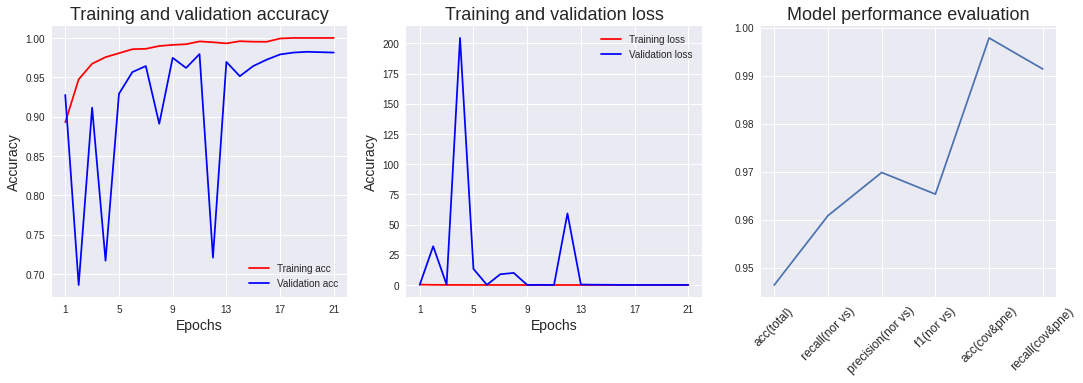

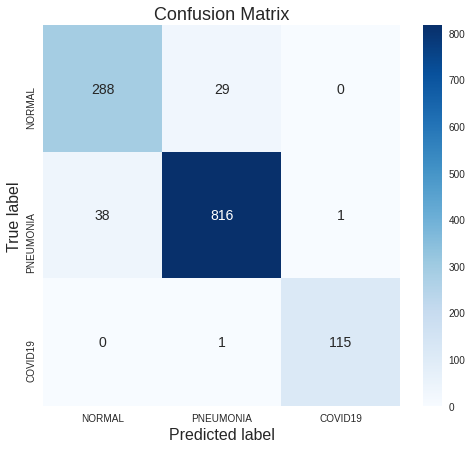

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rmsprop', layer_trainable=True, dense_layer=False, regularizer='l1')

# 7. Regularizer: L2 (0.1)

****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 41s 117ms/step - loss: 0.5160 - acc: 0.8420 - val_loss: 4531.5283 - val_acc: 0.3367
Epoch 2/100
263/263 [==============================] - 30s 114ms/step - loss: 0.1555 - acc: 0.9473 - val_loss: 0.3813 - val_acc: 0.9400
Epoch 3/100
263/263 [==============================] - 30s 112ms/step - loss: 0.1108 - acc: 0.9617 - val_loss: 0.8138 - val_acc: 0.7938
Epoch 4/100
263/263 [==============================] - 30s 113ms/step - loss: 0.0746 - acc: 0.9774 - val_loss: 0.2587 - val_acc: 0.9195
Epoch 5/100
263/263 [==============================] - 30s 113ms/step - loss: 0.0645 - acc: 0.9819 - val_loss: 0.1693 - val_acc: 0.9667
Epoch 6/100
263/263 [==============================] - 30s 113ms/step - loss: 0.0443 - acc: 0.9856 - val_loss: 1.1250 - val_acc: 0.9190
Epoch 7/100
263/263 [==============================] - 30s 113ms/step - loss: 0.0

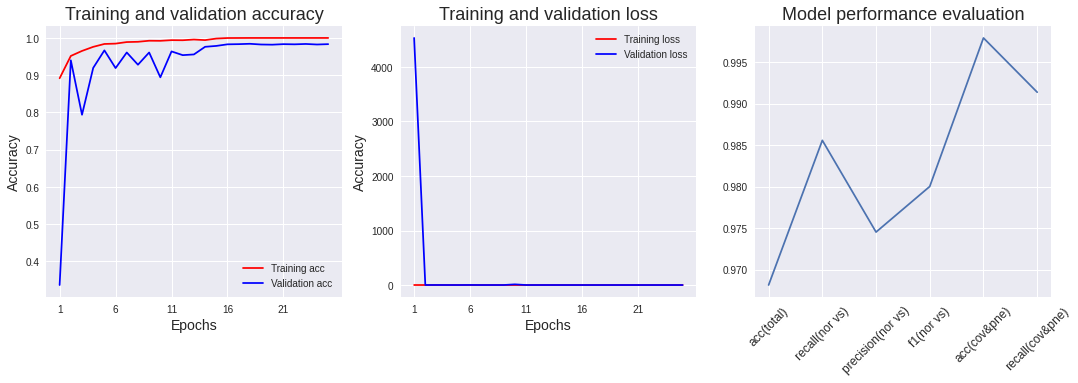

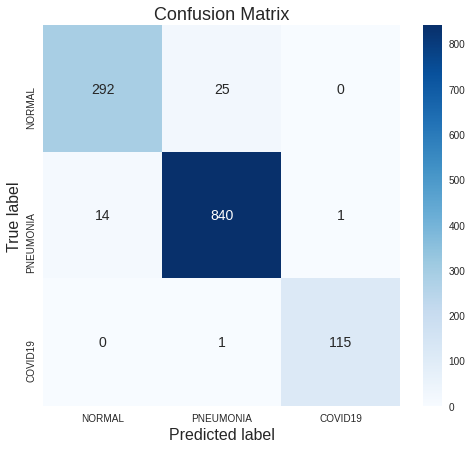

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rmsprop', layer_trainable=True, dense_layer=False, regularizer='l2')

# 8. Regularizer: L1 + L2 (0.1)

****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 41s 117ms/step - loss: 0.4957 - acc: 0.8489 - val_loss: 0.7428 - val_acc: 0.7052
Epoch 2/100
263/263 [==============================] - 30s 113ms/step - loss: 0.1858 - acc: 0.9452 - val_loss: 0.5547 - val_acc: 0.8752
Epoch 3/100
263/263 [==============================] - 29s 112ms/step - loss: 0.1101 - acc: 0.9642 - val_loss: 0.1407 - val_acc: 0.9586
Epoch 4/100
263/263 [==============================] - 29s 112ms/step - loss: 0.0720 - acc: 0.9777 - val_loss: 32.1472 - val_acc: 0.6314
Epoch 5/100
263/263 [==============================] - 29s 112ms/step - loss: 0.0597 - acc: 0.9807 - val_loss: 0.2168 - val_acc: 0.9581
Epoch 6/100
263/263 [==============================] - 29s 112ms/step - loss: 0.0479 - acc: 0.9840 - val_loss: 0.1660 - val_acc: 0.9729
Epoch 7/100
263/263 [==============================] - 29s 112ms/step - loss: 0.026

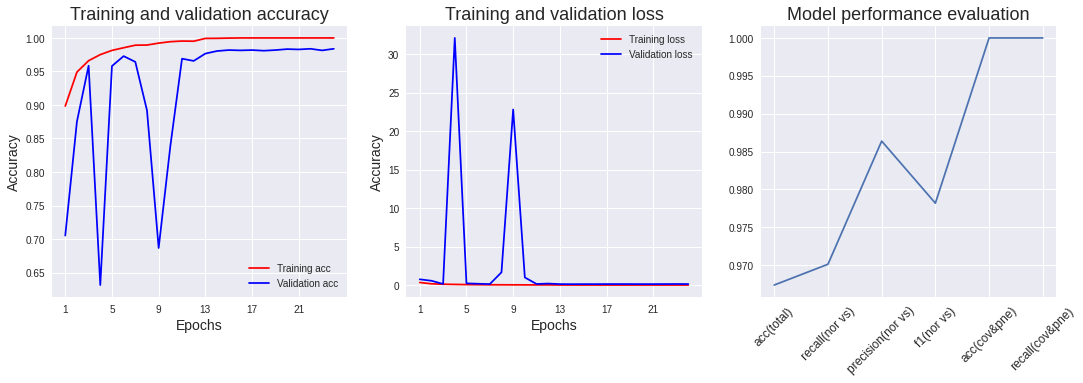

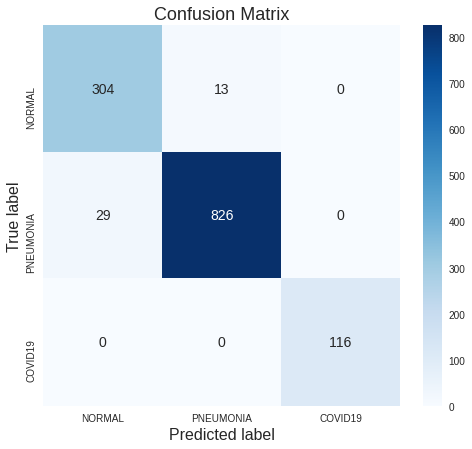

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rmsprop', layer_trainable=True, dense_layer=False, regularizer=True)

# 9. Freezing pre-trained model layer: 50% 
> # Dense layer: O + Dropout(0.5)
> # Reugularizer: L1 + L2 (0.1)




****************************************InceptionV3_rmsprop****************************************
Epoch 1/100
263/263 [==============================] - 28s 78ms/step - loss: 1644.3662 - acc: 0.6003 - val_loss: 131.5263 - val_acc: 0.3462
Epoch 2/100
263/263 [==============================] - 19s 73ms/step - loss: 131.0771 - acc: 0.3392 - val_loss: 130.7931 - val_acc: 0.3114
Epoch 3/100
263/263 [==============================] - 19s 73ms/step - loss: 131.0624 - acc: 0.3353 - val_loss: 131.2290 - val_acc: 0.3114
Epoch 4/100
263/263 [==============================] - 19s 72ms/step - loss: 131.0661 - acc: 0.3384 - val_loss: 130.9698 - val_acc: 0.3114
Epoch 5/100
263/263 [==============================] - 19s 72ms/step - loss: 131.0620 - acc: 0.3222 - val_loss: 131.1119 - val_acc: 0.3114
Epoch 6/100
263/263 [==============================] - 19s 73ms/step - loss: 131.0633 - acc: 0.3380 - val_loss: 131.0516 - val_acc: 0.3424
Epoch 7/100
263/263 [==============================] - 19s 73ms/s

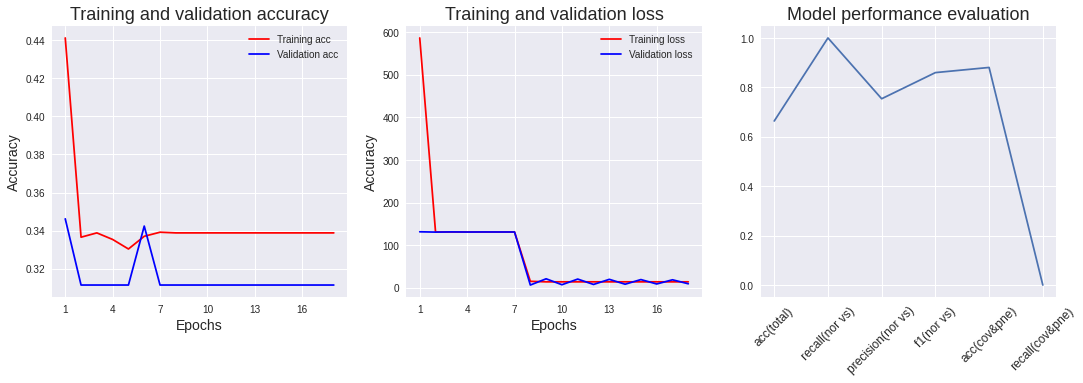

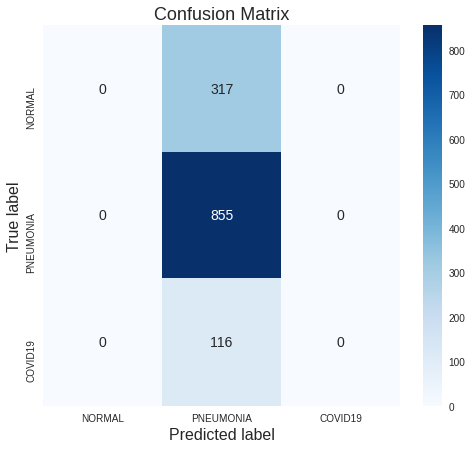

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
inception_v3 = pre_trained_model(model_name='InceptionV3', batch_size=32, epochs=100, opt_option='rmsprop', layer_trainable='half', dense_layer='drop_out', regularizer=True)

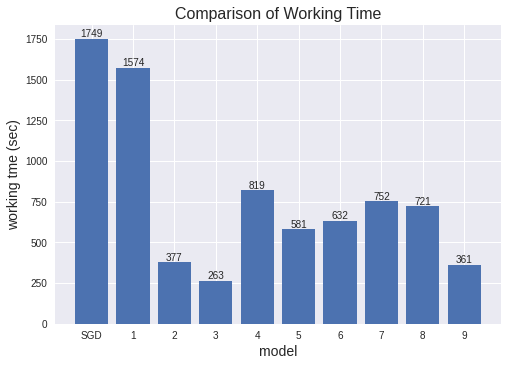

In [17]:
# Visualization of Working Time

x = ['SGD', '1', '2', '3', '4', '5', '6', '7', '8', '9']
y = [1749,  1574, 377, 263, 819, 581, 632, 752, 721, 361]

plt.bar(x, y)
plt.style.use(['seaborn'])
plt.title('Comparison of Working Time', fontsize=16)
plt.xlabel('model', fontsize=14)
plt.ylabel('working tme (sec)', fontsize=14)

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 
             fontsize = 10, 
             horizontalalignment='center',
             verticalalignment='bottom') 

plt.show()